In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, time, sys, os, gc
from codeE.generate_data import SinteticData
from codeE.representation import *
from codeE.utils import *
from codeE.learning_models import *
from codeE.baseline import RaykarMC,LabelInference
from codeE.MixtureofGroups import GroupMixtureGlo, GroupMixtureInd

import matplotlib
font = {'family' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

matplotlib.rc('axes', titlesize=25)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=25)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
ms = 15 #markersize
lw = 4

to_check = [100,2000,5000,10000,15000,25000,40000]
to_check

Using TensorFlow backend.


[100, 2000, 5000, 10000, 15000, 25000, 40000]

### data representation (labels + annotator reps)

100
2000
5000
10000
15000
25000
40000


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


CIFAR example 50k exaples, 10 classes -- memory consume of representation


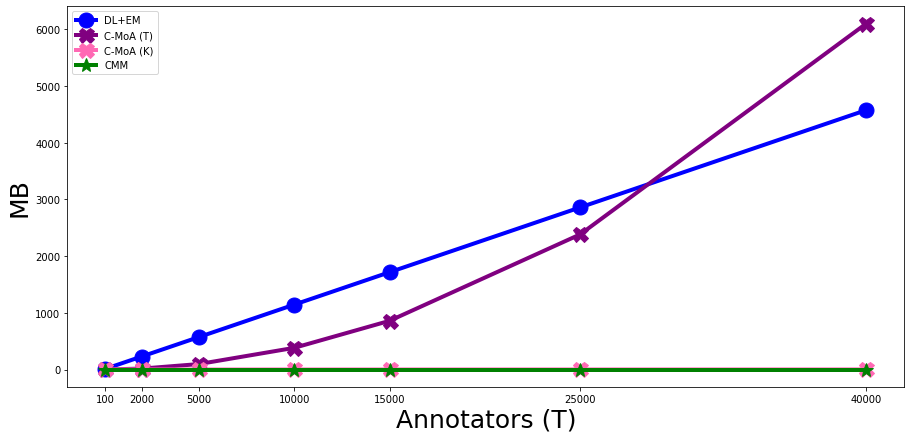

In [2]:
dlem_consume = []
ours_consume_I = []
ours_consume_I3 = []

N = 3000
K = 10
T_i = 5
for t in to_check:
    print(t)
    y_ann = np.zeros((N,t,K),dtype='float32') #int8 - annotations
    dlem_consume.append(y_ann.nbytes/(1024*1024)) #MB
    
    ann_id = np.zeros((t,t),dtype='float32') #ann representation: A_t
    ours_consume_I.append( ann_id.nbytes/(1024*1024) )
    
    ann_id = np.zeros((t,K),dtype='float32') #ann representation: A_t
    ours_consume_I3.append( ann_id.nbytes/(1024*1024) )
    #ours_consume2.append( N*T_i*t_aux.nbytes/(1024*1024) ) #identity consume
    del y_ann, ann_id
    gc.collect()

ours_consume = np.zeros((N,K),dtype='float32').nbytes/(1024*1024) #global
ours_consume_I = np.asarray(ours_consume_I)
ours_consume_I += np.zeros((N,T_i,K),dtype='float32').nbytes/(1024*1024) #annotations: y_il
ours_consume_I += np.zeros((N,T_i),dtype='float32').nbytes/(1024*1024) #identity: a_il

ours_consume_I3 = np.asarray(ours_consume_I3)
ours_consume_I3 += np.zeros((N,T_i,K),dtype='float32').nbytes/(1024*1024) #annotations: y_il
ours_consume_I3 += np.zeros((N,T_i),dtype='float32').nbytes/(1024*1024) #identity: a_il

print("CIFAR example 50k exaples, 10 classes -- memory consume of representation")

plt.figure(figsize=(15,7))
plt.plot(to_check, dlem_consume,'bo-',label="DL+EM", markersize=ms,linewidth=lw)
plt.plot(to_check, ours_consume_I,'X-',label="C-MoA (T)",color='purple', markersize=ms,linewidth=lw)
plt.plot(to_check, ours_consume_I3,'X-',label="C-MoA (K)",color='hotpink', markersize=ms,linewidth=lw)
plt.plot(to_check,np.tile(ours_consume,len(to_check)),'g*-',label="CMM", markersize=ms,linewidth=lw)

#plt.hlines(16000,0,to_check[-1], color='r', label="Our memory limit")

plt.xticks(to_check)
plt.ylabel("MB")
plt.xlabel("Annotators (T)")
#plt.yscale('log')

plt.legend()
plt.show()

### parameters modeled

100
2000
5000
10000
15000
25000
40000
CIFAR example 50k exaples, 10 classes -- memory consume of representation


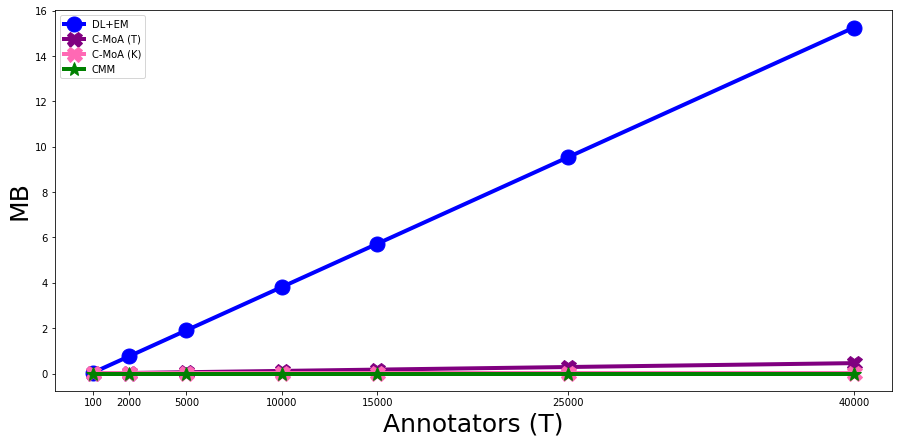

In [3]:
dlem_consume = []
ours_consume_I = []
ours_consume_I3 = []

N = 50000
K = 10
T_i = 5
M = 3
for t in to_check:
    print(t)
    betas = np.zeros((t,K,K),dtype='float32') #conf matrix - p(y|z)
    dlem_consume.append(betas.nbytes/(1024*1024)) #MB
    
    group_ass = np.zeros((t,M),dtype='float32') #group assignemnt p(g|a)
    ours_consume_I.append( group_ass.nbytes/(1024*1024) )
    
    #t_aux = np.zeros((t,K),dtype='float32') #ann representation
    #ours_consume_I3.append( t_aux.nbytes/(1024*1024) )
    del betas, group_ass
    gc.collect()

dlem_consume = np.asarray(dlem_consume)
#dlem_consume += np.zeros((K),dtype='float32').nbytes/(1024*1024) #class prob - p(z)
#dlem_consume += np.zeros((N,K),dtype='float32').nbytes/(1024*1024) # Q

ours_consume = np.zeros((M,K,K),dtype='float32').nbytes/(1024*1024) #conf matrix
ours_consume += np.zeros((M),dtype='float32').nbytes/(1024*1024) # mixing coef - p(g)
#ours_consume += np.zeros((N,K,K,M),dtype='float32').nbytes/(1024*1024) # Q

ours_consume_I = np.asarray(ours_consume_I)
ours_consume_I += np.zeros((M,K,K),dtype='float32').nbytes/(1024*1024) #conf matrix
#ours_consume_I += np.zeros((N,T_i,K,M),dtype='float32').nbytes/(1024*1024) # Q

ours_consume_I3 = np.zeros((M,K,K),dtype='float32').nbytes/(1024*1024) #conf matrix
ours_consume_I3 += np.zeros((M,K,K+M),dtype='float32').nbytes/(1024*1024) #p(g|a)
#ours_consume_I3 += np.zeros((N,T_i,K,M),dtype='float32').nbytes/(1024*1024) # Q

print("CIFAR example 50k exaples, 10 classes -- memory consume of representation")

plt.figure(figsize=(15,7))
plt.plot(to_check, dlem_consume,'bo-',label="DL+EM", markersize=ms,linewidth=lw)
plt.plot(to_check, ours_consume_I,'X-',label="C-MoA (T)",color='purple', markersize=ms,linewidth=lw)
plt.plot(to_check, np.tile(ours_consume_I3,len(to_check)),'X-',label="C-MoA (K)",color='hotpink', markersize=ms,linewidth=lw)
plt.plot(to_check,np.tile(ours_consume,len(to_check)),'g*-',label="CMM", markersize=ms,linewidth=lw)

#plt.hlines(16000,0,to_check[-1], color='r', label="Our memory limit")

plt.xticks(to_check)
plt.ylabel("MB")
plt.xlabel("Annotators (T)")
#plt.yscale('log')
plt.legend()
plt.show()

In [2]:
folder = "."
X_train = np.loadtxt(folder+"/synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(folder+"/synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth

X_test = np.loadtxt(folder+"/synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(folder+"/synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth
N = Z_train.shape[0]
GenerateData = SinteticData(state=None)

#CONFUSION MATRIX CHOOSE
GenerateData.set_probas(asfile=True,file_matrix='./synthetic/simple/matrix_datasim_normal.csv',file_groups ='./synthetic/simple/groups_datasim_normal.csv')

#GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_badMV.csv',file_groups =path+'/synthetic/simple/groups_datasim_badMV.csv')

In [3]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [4]:
to_check = [100,2000,5000,10000,15000,25000,40000]
T_data = 10 
M_seted = 5
BATCH_SIZE= 64

annot_acc = []
raykar_exec = []
raykar_init = []
ourglobal_exec = []
ourglobal_init = []
ourindiv1_exec = []
ourindiv1_init = []
ourindiv2_exec = []
ourindiv2_init = []
ourindiv3_exec = []
ourindiv3_init = []
ourindiv3_exec_v2 = []
ourindiv3_init_v2 = []
mv_exec = []
ds_exec = []
DL_exec = []
for Tmax in to_check:
    aux_annot_acc = []
    aux_raykar_exec = []
    aux_raykar_init = []
    aux_ourglobal_exec = []
    aux_ourglobal_init = []
    aux_ourindiv1_exec = []
    aux_ourindiv1_init = []
    aux_ourindiv2_exec = []
    aux_ourindiv2_init = []
    aux_ourindiv3_exec = []
    aux_ourindiv3_init = []
    aux_ourindiv3_exec_v2 = []
    aux_ourindiv3_init_v2 = []
    aux_mv_exec = []
    aux_ds_exec = []
    aux_DL_exec = []
    for _ in range(10):
        y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=True)
        T = y_obs.shape[1]
        #annot_acc.append(np.mean(GenerateData.yo_label == Z_train))

        #----------------------------RAYKAR---------------------------#
        y_obs_categorical = set_representation(y_obs,'onehot') 
        raykarMC = RaykarMC(X_train.shape[1:],y_obs_categorical.shape[-1],Tmax,epochs=1)
        raykarMC.define_model("mlp",16,1,BatchN=False,drop=0.2)
        logL_hists,i = raykarMC.multiples_run(1,X_train,y_obs_categorical,max_iter=5,batch_size=BATCH_SIZE)

        aux_raykar_exec.append(raykarMC.current_exectime)
        aux_raykar_init.append(raykarMC.init_exectime)

        del raykarMC
        gc.collect()
        keras.backend.clear_session()
        #----------------------------RAYKAR---------------------------#

        #----------------------------Ours Global---------------------------#
        r_obs = set_representation(y_obs,"repeat")
        K = r_obs.shape[1]
        gMixture_Global = GroupMixtureGlo(X_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1) 
        gMixture_Global.define_model("mlp",16,1,BatchN=False,drop=0.2)
        logL_hists,i_r = gMixture_Global.multiples_run(1,X_train,r_obs,max_iter=5, batch_size=BATCH_SIZE)

        aux_ourglobal_exec.append(gMixture_Global.current_exectime)
        aux_ourglobal_init.append(gMixture_Global.init_exectime)
    
        del gMixture_Global
        gc.collect()
        keras.backend.clear_session()
        #----------------------------Ours Global---------------------------#
        
        #----------------------------Ours Individual---------------------------#
        Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
        T_idx_unique = np.arange(T).reshape(-1,1)
        A = keras.utils.to_categorical(np.arange(T), num_classes=T) #fast way
        A_rep = np.zeros((T, K))
        for i in range(N):
            for l, t_idx in enumerate(T_idx[i]):
                obs_t = Y_ann_train[i][l].argmax(axis=-1)
                A_rep[t_idx, obs_t] += 1
        gMixture_Ind = GroupMixtureInd(X_train.shape[1:],Kl=K,M=M_seted,epochs=1) 
        gMixture_Ind.define_model("mlp",16,1,BatchN=False,drop=0.2)
        gMixture_Ind.define_model_group("perceptron",T, M_seted, embed=True, embed_M=A, BatchN=True,bias=False)
        
        logL_hists,i = gMixture_Ind.multiples_run(1,X_train,Y_ann_train, T_idx, A=[],max_iter=5,
                                                  pre_init_g=0, pre_init_z= 3, batch_size=BATCH_SIZE)
        
        aux_ourindiv1_exec.append(gMixture_Ind.current_exectime)
        aux_ourindiv1_init.append(gMixture_Ind.init_exectime)
        
        del gMixture_Ind
        gc.collect()
        keras.backend.clear_session()

        gMixture_Ind = GroupMixtureInd(X_train.shape[1:],Kl=K,M=M_seted,epochs=1) 
        gMixture_Ind.define_model("mlp",16,1,BatchN=False,drop=0.2) 
        logL_hists,i_r = gMixture_Ind.multiples_run(1,X_train,Y_ann_train, T_idx, A=[],
                                                    pre_init_z=3,batch_size=BATCH_SIZE,max_iter=5)
        
        aux_ourindiv2_exec.append(gMixture_Ind.current_exectime)
        aux_ourindiv2_init.append(gMixture_Ind.init_exectime)
        
        del gMixture_Ind
        gc.collect()
        keras.backend.clear_session()

        gMixture_Ind = GroupMixtureInd(X_train.shape[1:],Kl=K,M=M_seted,epochs=1) 
        gMixture_Ind.define_model("mlp",16,1,BatchN=False,drop=0.2) 
        gMixture_Ind.define_model_group("mlp", A_rep.shape[1], K*M_seted, 1, BatchN=False, embed=False) #con BN

        logL_hists,i_r = gMixture_Ind.multiples_run(1,X_train,Y_ann_train, T_idx, A=A_rep,
                                                    pre_init_g=0, pre_init_z=3, batch_size=BATCH_SIZE,max_iter=5)
        
        aux_ourindiv3_exec.append(gMixture_Ind.current_exectime)
        aux_ourindiv3_init.append(gMixture_Ind.init_exectime)
        
        del gMixture_Ind
        gc.collect()
        keras.backend.clear_session()
        
        gMixture_Ind = GroupMixtureInd(X_train.shape[1:],Kl=K,M=M_seted,epochs=1) 
        gMixture_Ind.define_model("mlp",16,1,BatchN=False,drop=0.2) 
        gMixture_Ind.define_model_group("mlp", A_rep.shape[0], K*M_seted,1, embed=True, embed_M=A_rep) 

        logL_hists,i_r = gMixture_Ind.multiples_run(1,X_train,Y_ann_train, T_idx, A=[],
                                                    pre_init_g=0, pre_init_z=3, batch_size=BATCH_SIZE,max_iter=5)
        
        aux_ourindiv3_exec_v2.append(gMixture_Ind.current_exectime)
        aux_ourindiv3_init_v2.append(gMixture_Ind.init_exectime)
        
        del gMixture_Ind
        gc.collect()
        keras.backend.clear_session()
        #----------------------------Ours Individual---------------------------#
        
        
        #----------------------------Majority Voting---------------------------#
        start_t = time.time()
        mv_soft = majority_voting(r_obs,repeats=True,probas=False) #Global: solo divide y argmax
        #mv_soft = majority_voting(y_obs,repeats=False,probas=True) #Individual: agrega sobre todo
        aux_mv_exec.append(time.time()-start_t)
        #----------------------------Majority Voting---------------------------#
        
        
        #----------------------------Dawid and Skene---------------------------#
        label_I = LabelInference(y_obs,1e-10, type_inf = 'ds', max_iter=5)
        ds_labels,ds_conf = label_I.DS_labels()
        aux_ds_exec.append(label_I.DS_current_exectime)
        del label_I
        gc.collect()
        #----------------------------Dawid and Skene---------------------------#
        
        
        #----------------------------Second phase training---------------------#
        time_callback = TimeHistory()
        model_mvsoft = MLP_Keras(X_train.shape[1:],mv_soft.shape[1],16,1,BN=False,drop=0.2)
        model_mvsoft.compile(loss='categorical_crossentropy',optimizer='adam')
        model_mvsoft.fit(X_train, mv_soft, epochs=5,batch_size=BATCH_SIZE,verbose=1,callbacks=[time_callback])
        DL_itertime = time_callback.times[-1]
        aux_DL_exec.append(DL_itertime)
        del model_mvsoft
        gc.collect()
        keras.backend.clear_session()
        #----------------------------Second phase training---------------------#
        
        
    raykar_exec.append(np.mean(aux_raykar_exec))
    raykar_init.append(np.mean(aux_raykar_init))
    ourglobal_exec.append(np.mean(aux_ourglobal_exec))
    ourglobal_init.append(np.mean(aux_ourglobal_init))
    ourindiv1_exec.append(np.mean(aux_ourindiv1_exec))
    ourindiv1_init.append(np.mean(aux_ourindiv1_init))
    ourindiv2_exec.append(np.mean(aux_ourindiv2_exec))
    ourindiv2_init.append(np.mean(aux_ourindiv2_init))
    ourindiv3_exec.append(np.mean(aux_ourindiv3_exec))
    ourindiv3_init.append(np.mean(aux_ourindiv3_init))
    ourindiv3_exec_v2.append(np.mean(aux_ourindiv3_exec_v2))
    ourindiv3_init_v2.append(np.mean(aux_ourindiv3_init_v2))
    mv_exec.append(np.mean(aux_mv_exec))
    ds_exec.append(np.mean(aux_ds_exec))
    DL_exec.append(np.mean(aux_DL_exec))
    
raykar_exec = np.asarray(raykar_exec)
raykar_init = np.asarray(raykar_init)
ourglobal_exec = np.asarray(ourglobal_exec)
ourglobal_init = np.asarray(ourglobal_init)
ourindiv1_exec = np.asarray(ourindiv1_exec)
ourindiv1_init = np.asarray(ourindiv1_init)
ourindiv2_exec = np.asarray(ourindiv2_exec)
ourindiv2_init = np.asarray(ourindiv2_init)
ourindiv3_exec = np.asarray(ourindiv3_exec)
ourindiv3_init = np.asarray(ourindiv3_init)
ourindiv3_exec_v2 = np.asarray(ourindiv3_exec_v2)
ourindiv3_init_v2 = np.asarray(ourindiv3_init_v2)
mv_exec = np.asarray(mv_exec)
ds_exec = np.asarray(ds_exec)
DL_exec = np.asarray(DL_exec)
print("Done")

Needed params (units,deep,drop,BatchN?)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/5 
M step:WARNING:tensorflow:From /opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
 done,  E step: done //  (in 0.55 sec)	logL: -18507.895	
Iter 2/5 
M step: done,  E step: done //  (in 0.07 sec)	logL: -17218.809	Tol1: 0.06965	Tol2: 0.28452	
Iter 3/5 
M step: done,  E step: done //  (in 0.08 sec)	logL: -16915.912	Tol1: 0.01759	Tol2: 0.11163	
Iter 4/5 
M step: done,  E step: done //  (in 0.07 sec)	logL: -16826.625	Tol1: 0.00528	Tol2: 0.05148	
Iter 5/5 
M step: done,  E step: done 

M step: done,  E step: done //  (in 0.47 sec)	logL: -18565.900	
Iter 2/5 
M step: done,  E step: done //  (in 0.04 sec)	logL: -17287.754	Tol1: 0.06884	Tol2: 0.27709	
Iter 3/5 
M step: done,  E step: done //  (in 0.05 sec)	logL: -17045.609	Tol1: 0.01401	Tol2: 0.10359	
Iter 4/5 
M step: done,  E step: done //  (in 0.05 sec)	logL: -16980.637	Tol1: 0.00381	Tol2: 0.04611	
Iter 5/5 
M step: done,  E step: done //  (in 0.04 sec)	logL: -16946.492	Tol1: 0.00201	Tol2: 0.02036	
Finished training
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.002696 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 0.47 sec)	logL: -25212.861	
Iter 2/5
M step: done,  E step: done //  (in 0.05 sec)	logL: -24108.974	Tol1: 0.04378	Tol2: 0.40877	Tol3: 0.05539	
Iter 3/5
M step: done,  E step: done //  (in 0.05 sec)	logL: -23348.653	Tol1: 0.03154

M step: done,  E step: done //  (in 0.05 sec)	logL: -24406.686	Tol1: 0.02530	Tol2: 0.17295	Tol3: 0.01131	
Iter 4/5
M step: done,  E step: done //  (in 0.05 sec)	logL: -23754.912	Tol1: 0.02670	Tol2: 0.13913	Tol3: 0.01206	
Iter 5/5
M step: done,  E step: done //  (in 0.05 sec)	logL: -23107.077	Tol1: 0.02727	Tol2: 0.14978	Tol3: 0.01442	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A_t = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.001268 mins
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24739, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.33 sec)	logL: -26265.309	
Iter 2/5
M step: done,  E step: done //  (in 0.18 sec)	logL: -25220.637	Tol1: 0.03977	Tol2: 0.24078	
Iter 3/5
M step: done,  E step: done //  (in 0.18 sec)	logL: -24673.385	Tol1: 0.02170	Tol2: 0.16559	
Iter 4/5
M step: done,  E step: done //  (in 0.18 sec)	logL: -24229.630	Tol1: 0.01799	To

Representation for DS in 0.050507 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -18771.155115598303
2 	 -17548.495050895905 	0.3463	0.278953	0.065135
3 	 -17293.317386689465 	0.0781	0.205749	0.014541
4 	 -17225.605224724928 	0.0388	0.145039	0.003916
5 	 -17210.61562227583 	0.0256	0.091743	0.000870
6 	 -17206.218624129495 	0.0159	0.060201	0.000255
Class marginals
[0.35 0.34 0.32]
Estimation for DS in 1.799940 sec
Epoch 1/5
2457/2457 [==============================] - 0s 89us/step - loss: 0.9890
Epoch 2/5
2457/2457 [==============================] - 0s 24us/step - loss: 0.9188
Epoch 3/5
2457/2457 [==============================] - 0s 24us/step - loss: 0.8934
Epoch 4/5
2457/2457 [==============================] - 0s 20us/step - loss: 0.8762
Epoch 5/5
2457/2457 [==============================] - 0s 19us/step - loss: 0.8654
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/5 
M step: done,  E step: done //  

Initializing new EM...
A_t = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.001407 mins
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24456, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 0.67 sec)	logL: -22546.383	
Iter 2/5
M step: done,  E step: done //  (in 0.13 sec)	logL: -22306.840	Tol1: 0.01062	Tol2: 0.11988	
Iter 3/5
M step: done,  E step: done //  (in 0.12 sec)	logL: -22157.300	Tol1: 0.00670	Tol2: 0.07542	
Iter 4/5
M step: done,  E step: done //  (in 0.12 sec)	logL: -22005.647	Tol1: 0.00684	Tol2: 0.06436	
Iter 5/5
M step: done,  E step: done //  (in 0.13 sec)	logL: -21838.394	Tol1: 0.00760	Tol2: 0.06118	
Finished training!
Needed params (units,deep,drop,BatchN?)
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000368 mins
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (

2457/2457 [==============================] - 0s 19us/step - loss: 0.8931
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (2000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/5 
M step: done,  E step: done //  (in 0.56 sec)	logL: -20368.410	
Iter 2/5 
M step: done,  E step: done //  (in 0.10 sec)	logL: -18917.980	Tol1: 0.07121	Tol2: 0.13987	
Iter 3/5 
M step: done,  E step: done //  (in 0.09 sec)	logL: -18490.389	Tol1: 0.02260	Tol2: 0.05307	
Iter 4/5 
M step: done,  E step: done //  (in 0.09 sec)	logL: -18297.455	Tol1: 0.01043	Tol2: 0.02680	
Iter 5/5 
M step: done,  E step: done //  (in 0.09 sec)	logL: -18183.355	Tol1: 0.00624	Tol2: 0.01617	
Finished training
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.002818 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 0.54 sec)	logL: -24750.965

M step: done,  E step: done //  (in 0.09 sec)	logL: -18372.953	Tol1: 0.07037	Tol2: 0.12448	
Iter 3/5 
M step: done,  E step: done //  (in 0.09 sec)	logL: -17934.305	Tol1: 0.02387	Tol2: 0.05228	
Iter 4/5 
M step: done,  E step: done //  (in 0.09 sec)	logL: -17748.961	Tol1: 0.01033	Tol2: 0.02829	
Iter 5/5 
M step: done,  E step: done //  (in 0.09 sec)	logL: -17646.266	Tol1: 0.00579	Tol2: 0.01754	
Finished training
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.002960 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 0.46 sec)	logL: -25768.639	
Iter 2/5
M step: done,  E step: done //  (in 0.05 sec)	logL: -24403.974	Tol1: 0.05296	Tol2: 0.44185	Tol3: 0.09917	
Iter 3/5
M step: done,  E step: done //  (in 0.05 sec)	logL: -23653.908	Tol1: 0.03074	Tol2: 0.20411	Tol3: 0.01910	
Iter 4/5
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 1.30 sec)	logL: -24899.159	
Iter 2/5
M step: done,  E step: done //  (in 0.19 sec)	logL: -23629.977	Tol1: 0.05097	Tol2: 0.21825	
Iter 3/5
M step: done,  E step: done //  (in 0.18 sec)	logL: -22905.503	Tol1: 0.03066	Tol2: 0.17615	
Iter 4/5
M step: done,  E step: done //  (in 0.17 sec)	logL: -22268.140	Tol1: 0.02783	Tol2: 0.16310	
Iter 5/5
M step: done,  E step: done //  (in 0.16 sec)	logL: -21693.082	Tol1: 0.02582	Tol2: 0.15447	
Finished training!
Needed params (units,deep,drop,BatchN?)
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000618 mins
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24361, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.13 sec)	logL: -24337.475	
Iter 2/5
M step: done,  E step: done //  (in 0.17 sec)	logL: -22553.386	Tol1: 0.07331	Tol2: 0.32924	
Iter 3/5
M step: done,  E step: done //  (in 0.18 sec)	logL: -21

M step: done,  E step: done //  (in 0.51 sec)	logL: -24641.145	
Iter 2/5
M step: done,  E step: done //  (in 0.10 sec)	logL: -23916.221	Tol1: 0.02942	Tol2: 0.49273	Tol3: 0.09390	
Iter 3/5
M step: done,  E step: done //  (in 0.07 sec)	logL: -23360.984	Tol1: 0.02322	Tol2: 0.23290	Tol3: 0.03965	
Iter 4/5
M step: done,  E step: done //  (in 0.05 sec)	logL: -22738.945	Tol1: 0.02663	Tol2: 0.19198	Tol3: 0.04248	
Iter 5/5
M step: done,  E step: done //  (in 0.05 sec)	logL: -22114.093	Tol1: 0.02748	Tol2: 0.17921	Tol3: 0.04644	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A_t = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.001756 mins
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24725, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.35 sec)	logL: -24793.583	
Iter 2/5
M step: done,  E step: done //  (in 0.28 sec)	logL: -24210.129	Tol1: 0.02353	Tol2: 0.11976	
I

M step: done,  E step: done //  (in 0.07 sec)	logL: -24198.417	Tol1: 0.02474	Tol2: 0.17112	Tol3: 0.01155	
Iter 4/5
M step: done,  E step: done //  (in 0.07 sec)	logL: -23518.258	Tol1: 0.02811	Tol2: 0.14292	Tol3: 0.01193	
Iter 5/5
M step: done,  E step: done //  (in 0.06 sec)	logL: -22847.730	Tol1: 0.02851	Tol2: 0.14523	Tol3: 0.01542	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A_t = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.001739 mins
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24722, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.62 sec)	logL: -23882.480	
Iter 2/5
M step: done,  E step: done //  (in 0.45 sec)	logL: -23118.211	Tol1: 0.03200	Tol2: 0.12839	
Iter 3/5
M step: done,  E step: done //  (in 0.50 sec)	logL: -22495.709	Tol1: 0.02693	Tol2: 0.12005	
Iter 4/5
M step: done,  E step: done //  (in 0.44 sec)	logL: -21804.352	Tol1: 0.03073	To

Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24499, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.24 sec)	logL: -25736.164	
Iter 2/5
M step: done,  E step: done //  (in 0.17 sec)	logL: -22911.778	Tol1: 0.10974	Tol2: 0.28815	
Iter 3/5
M step: done,  E step: done //  (in 0.18 sec)	logL: -21843.449	Tol1: 0.04663	Tol2: 0.20373	
Iter 4/5
M step: done,  E step: done //  (in 0.22 sec)	logL: -20890.215	Tol1: 0.04364	Tol2: 0.18484	
Iter 5/5
M step: done,  E step: done //  (in 0.18 sec)	logL: -20066.452	Tol1: 0.03943	Tol2: 0.16876	
Finished training!
Representation for DS in 0.103043 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -12354.613018820724
2 	 -9686.774647099846 	0.3583	0.266968	0.215939
3 	 -9053.880290299274 	0.0382	10667.528320	0.065336
4 	 -8868.657549756465 	0.0169	52681.757812	0.020458
5 	 -8796.927745028946 	0.0084	62488.972656	0.008088
6 	 -8769.058210215095 	0.0033	56396.281250	0.003168
Class marginals
[0.3

M step: done,  E step: done //  (in 0.17 sec)	logL: -23945.657	Tol1: 0.04599	Tol2: 0.17857	
Iter 3/5
M step: done,  E step: done //  (in 0.16 sec)	logL: -23095.212	Tol1: 0.03552	Tol2: 0.16182	
Iter 4/5
M step: done,  E step: done //  (in 0.17 sec)	logL: -22269.870	Tol1: 0.03574	Tol2: 0.15587	
Iter 5/5
M step: done,  E step: done //  (in 0.17 sec)	logL: -21508.022	Tol1: 0.03421	Tol2: 0.15312	
Finished training!
Representation for DS in 0.117729 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -12539.40795683021
2 	 -9812.136137620184 	0.3532	0.271434	0.217496
3 	 -9218.105887301379 	0.0313	6639.342285	0.060540
4 	 -9042.162705374269 	0.0156	50995.445312	0.019087
5 	 -8978.157113965724 	0.0083	70090.273438	0.007079
6 	 -8946.929917988109 	0.0053	51276.632812	0.003478
Class marginals
[0.37 0.3  0.33]
Estimation for DS in 24.732228 sec
Epoch 1/5
2457/2457 [==============================] - 0s 96us/step - loss: 1.1071
Epoch 2/5
2457/2457 [==============================] - 0s 18us/step

Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24541, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.70 sec)	logL: -24839.988	
Iter 2/5
M step: done,  E step: done //  (in 0.45 sec)	logL: -24148.183	Tol1: 0.02785	Tol2: 0.09697	
Iter 3/5
M step: done,  E step: done //  (in 0.48 sec)	logL: -23580.734	Tol1: 0.02350	Tol2: 0.08201	
Iter 4/5
M step: done,  E step: done //  (in 0.50 sec)	logL: -22929.454	Tol1: 0.02762	Tol2: 0.10498	
Iter 5/5
M step: done,  E step: done //  (in 0.41 sec)	logL: -22228.721	Tol1: 0.03056	Tol2: 0.12745	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A_t = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.002363 mins
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24541, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.59 sec)	logL: -21668.713	
Iter 2/5
M step: done,  E step: don

2 	 -9866.289478143135 	0.3587	0.267179	0.212232
3 	 -9249.162545699592 	0.0375	7686.734863	0.062549
4 	 -9044.90670273118 	0.0205	47701.562500	0.022084
5 	 -8968.761251276434 	0.0100	63714.378906	0.008419
6 	 -8935.424266521793 	0.0036	50498.277344	0.003717
Class marginals
[0.37 0.3  0.33]
Estimation for DS in 23.461923 sec
Epoch 1/5
2457/2457 [==============================] - 0s 108us/step - loss: 1.3236
Epoch 2/5
2457/2457 [==============================] - 0s 19us/step - loss: 1.1813
Epoch 3/5
2457/2457 [==============================] - 0s 18us/step - loss: 1.0827
Epoch 4/5
2457/2457 [==============================] - 0s 18us/step - loss: 1.0102
Epoch 5/5
2457/2457 [==============================] - 0s 19us/step - loss: 0.9554
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (5000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/5 
M step: done,  E step: done //  (in 0.67 sec)	logL: -20536.564	
Iter 2/5 
M step: done,  E step: done //  (in 0.16 sec)	logL: -1

2457/2457 [==============================] - 0s 94us/step - loss: 1.1092
Epoch 2/5
2457/2457 [==============================] - 0s 26us/step - loss: 1.0207
Epoch 3/5
2457/2457 [==============================] - 0s 23us/step - loss: 0.9624
Epoch 4/5
2457/2457 [==============================] - 0s 21us/step - loss: 0.9234
Epoch 5/5
2457/2457 [==============================] - 0s 19us/step - loss: 0.9001
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (10000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/5 
M step: done,  E step: done //  (in 0.66 sec)	logL: -21266.385	
Iter 2/5 
M step: done,  E step: done //  (in 0.24 sec)	logL: -20408.914	Tol1: 0.04032	Tol2: 0.05321	
Iter 3/5 
M step: done,  E step: done //  (in 0.25 sec)	logL: -19799.500	Tol1: 0.02986	Tol2: 0.03609	
Iter 4/5 
M step: done,  E step: done //  (in 0.24 sec)	logL: -19458.953	Tol1: 0.01720	Tol2: 0.02186	
Iter 5/5 
M step: done,  E step: done //  (in 0.24 sec)	logL: -19262.355	Tol1: 0.01010	Tol2: 0.

M step: done,  E step: done //  (in 2.41 sec)	logL: -20211.497	
Iter 2/5
M step: done,  E step: done //  (in 1.82 sec)	logL: -19971.411	Tol1: 0.01188	Tol2: 0.14638	
Iter 3/5
M step: done,  E step: done //  (in 1.79 sec)	logL: -19943.986	Tol1: 0.00137	Tol2: 0.03151	
Iter 4/5
M step: done,  E step: done //  (in 1.80 sec)	logL: -19934.561	Tol1: 0.00047	Tol2: 0.01091	
Finished training!
Needed params (units,deep,drop,BatchN?)
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000746 mins
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24751, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.17 sec)	logL: -24709.400	
Iter 2/5
M step: done,  E step: done //  (in 0.22 sec)	logL: -23413.506	Tol1: 0.05245	Tol2: 0.23924	
Iter 3/5
M step: done,  E step: done //  (in 0.20 sec)	logL: -22390.899	Tol1: 0.04368	Tol2: 0.12417	
Iter 4/5
M step: done,  E step: done //  (in 0.21 sec)	logL: -21

Betas shape:  (10000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/5 
M step: done,  E step: done //  (in 0.74 sec)	logL: -20794.941	
Iter 2/5 
M step: done,  E step: done //  (in 0.25 sec)	logL: -19709.148	Tol1: 0.05221	Tol2: 0.06900	
Iter 3/5 
M step: done,  E step: done //  (in 0.25 sec)	logL: -19074.213	Tol1: 0.03222	Tol2: 0.04169	
Iter 4/5 
M step: done,  E step: done //  (in 0.24 sec)	logL: -18728.775	Tol1: 0.01811	Tol2: 0.02441	
Iter 5/5 
M step: done,  E step: done //  (in 0.27 sec)	logL: -18515.877	Tol1: 0.01137	Tol2: 0.01502	
Finished training
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.002282 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 0.47 sec)	logL: -25662.525	
Iter 2/5
M step: done,  E step: done //  (in 0.05 sec)	logL: -24612.698	Tol1: 0.04091	Tol2: 0.38933	Tol3: 0.04885	
Iter 3/5
M step: d

M step: done,  E step: done //  (in 0.25 sec)	logL: -19381.988	Tol1: 0.02725	Tol2: 0.03273	
Iter 4/5 
M step: done,  E step: done //  (in 0.24 sec)	logL: -19079.959	Tol1: 0.01558	Tol2: 0.01978	
Iter 5/5 
M step: done,  E step: done //  (in 0.27 sec)	logL: -18899.775	Tol1: 0.00944	Tol2: 0.01201	
Finished training
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.002763 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 0.47 sec)	logL: -24242.537	
Iter 2/5
M step: done,  E step: done //  (in 0.10 sec)	logL: -23235.697	Tol1: 0.04153	Tol2: 0.53926	Tol3: 0.11005	
Iter 3/5
M step: done,  E step: done //  (in 0.06 sec)	logL: -22458.395	Tol1: 0.03345	Tol2: 0.26424	Tol3: 0.05370	
Iter 4/5
M step: done,  E step: done //  (in 0.10 sec)	logL: -21743.768	Tol1: 0.03182	Tol2: 0.22076	Tol3: 0.05421	
Iter 5/5
M step: done,  E step:

M step: done,  E step: done //  (in 1.05 sec)	logL: -23394.466	
Iter 2/5
M step: done,  E step: done //  (in 0.15 sec)	logL: -22125.069	Tol1: 0.05426	Tol2: 0.27436	
Iter 3/5
M step: done,  E step: done //  (in 0.15 sec)	logL: -21054.038	Tol1: 0.04841	Tol2: 0.20733	
Iter 4/5
M step: done,  E step: done //  (in 0.15 sec)	logL: -19997.250	Tol1: 0.05019	Tol2: 0.19331	
Iter 5/5
M step: done,  E step: done //  (in 0.16 sec)	logL: -19059.535	Tol1: 0.04689	Tol2: 0.18407	
Finished training!
Needed params (units,deep,drop,BatchN?)
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000968 mins
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24652, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.28 sec)	logL: -22241.606	
Iter 2/5
M step: done,  E step: done //  (in 0.19 sec)	logL: -20659.461	Tol1: 0.07113	Tol2: 0.30995	
Iter 3/5
M step: done,  E step: done //  (in 0.18 sec)	logL: -19

M step: done,  E step: done //  (in 0.47 sec)	logL: -25425.476	
Iter 2/5
M step: done,  E step: done //  (in 0.05 sec)	logL: -24479.396	Tol1: 0.03721	Tol2: 0.38839	Tol3: 0.06863	
Iter 3/5
M step: done,  E step: done //  (in 0.06 sec)	logL: -23877.295	Tol1: 0.02460	Tol2: 0.18175	Tol3: 0.00859	
Iter 4/5
M step: done,  E step: done //  (in 0.05 sec)	logL: -23259.625	Tol1: 0.02587	Tol2: 0.15269	Tol3: 0.01312	
Iter 5/5
M step: done,  E step: done //  (in 0.05 sec)	logL: -22644.818	Tol1: 0.02643	Tol2: 0.15286	Tol3: 0.01967	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A_t = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.001842 mins
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24432, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 2.09 sec)	logL: -24339.828	
Iter 2/5
M step: done,  E step: done //  (in 0.85 sec)	logL: -23003.185	Tol1: 0.05492	Tol2: 0.13680	
I

M step: done,  E step: done //  (in 0.05 sec)	logL: -22572.448	Tol1: 0.03121	Tol2: 0.21350	Tol3: 0.02759	
Iter 4/5
M step: done,  E step: done //  (in 0.05 sec)	logL: -21928.999	Tol1: 0.02851	Tol2: 0.18521	Tol3: 0.02533	
Iter 5/5
M step: done,  E step: done //  (in 0.05 sec)	logL: -21418.687	Tol1: 0.02327	Tol2: 0.16650	Tol3: 0.02468	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A_t = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.002771 mins
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24502, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.86 sec)	logL: -24431.137	
Iter 2/5
M step: done,  E step: done //  (in 0.73 sec)	logL: -23289.815	Tol1: 0.04672	Tol2: 0.06774	
Iter 3/5
M step: done,  E step: done //  (in 0.80 sec)	logL: -22025.247	Tol1: 0.05430	Tol2: 0.10900	
Iter 4/5
M step: done,  E step: done //  (in 0.76 sec)	logL: -20463.036	Tol1: 0.07093	To

Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24694, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.32 sec)	logL: -24399.348	
Iter 2/5
M step: done,  E step: done //  (in 0.19 sec)	logL: -22845.651	Tol1: 0.06368	Tol2: 0.31793	
Iter 3/5
M step: done,  E step: done //  (in 0.18 sec)	logL: -21711.171	Tol1: 0.04966	Tol2: 0.13803	
Iter 4/5
M step: done,  E step: done //  (in 0.18 sec)	logL: -20508.254	Tol1: 0.05541	Tol2: 0.11549	
Iter 5/5
M step: done,  E step: done //  (in 0.17 sec)	logL: -19256.527	Tol1: 0.06104	Tol2: 0.13526	
Finished training!
Representation for DS in 0.166000 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -7427.053017101437
2 	 -5608.008834080854 	0.3233	0.111241	0.244921
3 	 -5068.198999457457 	0.0528	9116.339844	0.096257
4 	 -4870.194515107276 	0.0179	101397.390625	0.039068
5 	 -4774.10502863799 	0.0124	130976.640625	0.019730
6 	 -4720.820049231724 	0.0091	99939.523438	0.011161
Class marginals
[0.38

M step: done,  E step: done //  (in 0.18 sec)	logL: -23640.742	Tol1: 0.08230	Tol2: 0.42089	
Iter 3/5
M step: done,  E step: done //  (in 0.22 sec)	logL: -22140.207	Tol1: 0.06347	Tol2: 0.19058	
Iter 4/5
M step: done,  E step: done //  (in 0.19 sec)	logL: -20799.771	Tol1: 0.06054	Tol2: 0.13672	
Iter 5/5
M step: done,  E step: done //  (in 0.16 sec)	logL: -19616.049	Tol1: 0.05691	Tol2: 0.13909	
Finished training!
Representation for DS in 0.274068 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -7403.597527264342
2 	 -5646.286360778813 	0.3112	0.106628	0.237359
3 	 -5134.91933637039 	0.0512	10149.312500	0.090567
4 	 -4935.394348259202 	0.0205	100915.656250	0.038856
5 	 -4831.213616916541 	0.0138	133175.875000	0.021109
6 	 -4774.25364885434 	0.0105	94783.726562	0.011790
Class marginals
[0.36 0.3  0.34]
Estimation for DS in 54.825667 sec
Epoch 1/5
2457/2457 [==============================] - 0s 84us/step - loss: 1.0281
Epoch 2/5
2457/2457 [==============================] - 0s 19us/ste

M step: done,  E step: done //  (in 1.82 sec)	logL: -24377.556	
Iter 2/5
M step: done,  E step: done //  (in 0.81 sec)	logL: -23100.874	Tol1: 0.05237	Tol2: 0.07819	
Iter 3/5
M step: done,  E step: done //  (in 0.74 sec)	logL: -21657.206	Tol1: 0.06249	Tol2: 0.12488	
Iter 4/5
M step: done,  E step: done //  (in 0.81 sec)	logL: -19912.632	Tol1: 0.08055	Tol2: 0.17417	
Iter 5/5
M step: done,  E step: done //  (in 0.81 sec)	logL: -18073.698	Tol1: 0.09235	Tol2: 0.22298	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A_t = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.002919 mins
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24472, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 2.88 sec)	logL: -16774.393	
Iter 2/5
M step: done,  E step: done //  (in 2.33 sec)	logL: -16480.102	Tol1: 0.01754	Tol2: 0.16435	
Iter 3/5
M step: done,  E step: done //  (in 2.34 sec)	lo

Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -5439.407233451581
2 	 -4211.888824014258 	0.2110	0.079016	0.225671
3 	 -3766.330399599385 	0.0672	3683.116211	0.105786
4 	 -3591.7804205742 	0.0163	69789.921875	0.046345
5 	 -3504.773994904578 	0.0113	113590.000000	0.024224
6 	 -3445.736662465251 	0.0088	90743.062500	0.016845
Class marginals
[0.37 0.27 0.36]
Estimation for DS in 69.986439 sec
Epoch 1/5
2457/2457 [==============================] - 0s 85us/step - loss: 1.0874
Epoch 2/5
2457/2457 [==============================] - 0s 19us/step - loss: 1.0060
Epoch 3/5
2457/2457 [==============================] - 0s 19us/step - loss: 0.9526
Epoch 4/5
2457/2457 [==============================] - 0s 19us/step - loss: 0.9168
Epoch 5/5
2457/2457 [==============================] - 0s 19us/step - loss: 0.8876
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (25000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/5 
M step: done,  E step: done //  (in 0.90 sec)	logL: -21131

6 	 -3434.2278221379665 	0.0121	87102.476562	0.016229
Class marginals
[0.37 0.28 0.35]
Estimation for DS in 71.412224 sec
Epoch 1/5
2457/2457 [==============================] - 0s 96us/step - loss: 1.0093
Epoch 2/5
2457/2457 [==============================] - 0s 24us/step - loss: 0.9408
Epoch 3/5
2457/2457 [==============================] - 0s 23us/step - loss: 0.9032
Epoch 4/5
2457/2457 [==============================] - 0s 23us/step - loss: 0.8775
Epoch 5/5
2457/2457 [==============================] - 0s 21us/step - loss: 0.8618
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (25000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/5 
M step: done,  E step: done //  (in 0.82 sec)	logL: -21003.240	
Iter 2/5 
M step: done,  E step: done //  (in 0.38 sec)	logL: -20382.430	Tol1: 0.02956	Tol2: 0.03471	
Iter 3/5 
M step: done,  E step: done //  (in 0.38 sec)	logL: -19882.473	Tol1: 0.02453	Tol2: 0.02461	
Iter 4/5 
M step: done,  E step: done //  (in 0.38 sec)	logL: -19

Doing clustering...Done!
Get init alphas in 0.002278 mins
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24530, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 3.56 sec)	logL: -15850.346	
Iter 2/5
M step: done,  E step: done //  (in 3.21 sec)	logL: -15502.214	Tol1: 0.02196	Tol2: 0.17553	
Iter 3/5
M step: done,  E step: done //  (in 3.12 sec)	logL: -15377.456	Tol1: 0.00805	Tol2: 0.07601	
Iter 4/5
M step: done,  E step: done //  (in 3.12 sec)	logL: -15276.864	Tol1: 0.00654	Tol2: 0.06682	
Iter 5/5
M step: done,  E step: done //  (in 3.12 sec)	logL: -15168.041	Tol1: 0.00712	Tol2: 0.06144	
Finished training!
Needed params (units,deep,drop,BatchN?)
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.001661 mins
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24530, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.16 sec)	lo

M step: done,  E step: done //  (in 3.06 sec)	logL: -14160.708	Tol1: 0.02204	Tol2: 0.19044	
Iter 3/5
M step: done,  E step: done //  (in 3.09 sec)	logL: -14087.396	Tol1: 0.00518	Tol2: 0.07871	
Iter 4/5
M step: done,  E step: done //  (in 3.04 sec)	logL: -14023.924	Tol1: 0.00451	Tol2: 0.06589	
Iter 5/5
M step: done,  E step: done //  (in 3.09 sec)	logL: -13937.639	Tol1: 0.00615	Tol2: 0.06110	
Finished training!
Needed params (units,deep,drop,BatchN?)
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.001896 mins
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24722, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 1.11 sec)	logL: -28285.691	
Iter 2/5
M step: done,  E step: done //  (in 0.18 sec)	logL: -25530.422	Tol1: 0.09741	Tol2: 0.56745	
Iter 3/5
M step: done,  E step: done //  (in 0.19 sec)	logL: -23798.508	Tol1: 0.06784	Tol2: 0.32082	
Iter 4/5
M step: done,  E step: done

Betas shape:  (40000, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/5 
M step: done,  E step: done //  (in 0.86 sec)	logL: -21115.188	
Iter 2/5 
M step: done,  E step: done //  (in 0.43 sec)	logL: -20520.348	Tol1: 0.02817	Tol2: 0.03150	
Iter 3/5 
M step: done,  E step: done //  (in 0.43 sec)	logL: -19999.191	Tol1: 0.02540	Tol2: 0.02247	
Iter 4/5 
M step: done,  E step: done //  (in 0.43 sec)	logL: -19637.699	Tol1: 0.01808	Tol2: 0.01460	
Iter 5/5 
M step: done,  E step: done //  (in 0.45 sec)	logL: -19397.477	Tol1: 0.01223	Tol2: 0.00904	
Finished training
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.002347 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 0.51 sec)	logL: -24744.494	
Iter 2/5
M step: done,  E step: done //  (in 0.08 sec)	logL: -23842.659	Tol1: 0.03645	Tol2: 0.38491	Tol3: 0.05966	
Iter 3/5
M step: d

M step: done,  E step: done //  (in 0.42 sec)	logL: -19820.836	Tol1: 0.03136	Tol2: 0.02720	
Iter 4/5 
M step: done,  E step: done //  (in 0.42 sec)	logL: -19479.551	Tol1: 0.01722	Tol2: 0.01325	
Iter 5/5 
M step: done,  E step: done //  (in 0.42 sec)	logL: -19279.754	Tol1: 0.01026	Tol2: 0.00681	
Finished training
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.002877 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 0.48 sec)	logL: -25567.465	
Iter 2/5
M step: done,  E step: done //  (in 0.05 sec)	logL: -24236.812	Tol1: 0.05204	Tol2: 0.43852	Tol3: 0.08112	
Iter 3/5
M step: done,  E step: done //  (in 0.05 sec)	logL: -23531.272	Tol1: 0.02911	Tol2: 0.21287	Tol3: 0.01278	
Iter 4/5
M step: done,  E step: done //  (in 0.05 sec)	logL: -22870.942	Tol1: 0.02806	Tol2: 0.17863	Tol3: 0.02291	
Iter 5/5
M step: done,  E step:

M step: done,  E step: done //  (in 0.43 sec)	logL: -19090.203	Tol1: 0.00677	Tol2: 0.00554	
Finished training
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.002287 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 0.50 sec)	logL: -24712.546	
Iter 2/5
M step: done,  E step: done //  (in 0.08 sec)	logL: -23809.577	Tol1: 0.03654	Tol2: 0.59601	Tol3: 0.08550	
Iter 3/5
M step: done,  E step: done //  (in 0.06 sec)	logL: -23161.071	Tol1: 0.02724	Tol2: 0.26651	Tol3: 0.05065	
Iter 4/5
M step: done,  E step: done //  (in 0.05 sec)	logL: -22491.003	Tol1: 0.02893	Tol2: 0.20701	Tol3: 0.04792	
Iter 5/5
M step: done,  E step: done //  (in 0.06 sec)	logL: -21881.005	Tol1: 0.02712	Tol2: 0.18279	Tol3: 0.04822	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A_t = Son ortonormales / No fueron ent

M step: done,  E step: done //  (in 0.51 sec)	logL: -25643.426	
Iter 2/5
M step: done,  E step: done //  (in 0.07 sec)	logL: -24792.363	Tol1: 0.03319	Tol2: 0.37652	Tol3: 0.06079	
Iter 3/5
M step: done,  E step: done //  (in 0.06 sec)	logL: -24177.331	Tol1: 0.02481	Tol2: 0.16016	Tol3: 0.01734	
Iter 4/5
M step: done,  E step: done //  (in 0.05 sec)	logL: -23484.632	Tol1: 0.02865	Tol2: 0.13122	Tol3: 0.02111	
Iter 5/5
M step: done,  E step: done //  (in 0.05 sec)	logL: -22742.530	Tol1: 0.03160	Tol2: 0.13880	Tol3: 0.02769	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A_t = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.002764 mins
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (24507, 5, 3)
Iter 1/5
M step: done,  E step: done //  (in 2.29 sec)	logL: -24248.211	
Iter 2/5
M step: done,  E step: done //  (in 1.09 sec)	logL: -22226.103	Tol1: 0.08339	Tol2: 0.11185	
I

In [34]:
import pandas as pd
df = pd.DataFrame({"Raykar exec": raykar_exec, "Raykar init": raykar_init,
                  "MV exec": mv_exec, "DS exec": ds_exec, "DL exec": DL_exec,
                    "Our exec": ourglobal_exec,"Our init": ourglobal_init,
                   "Our Indiv1 exec" : ourindiv1_exec,  "Our Indiv1 init" : ourindiv1_init,
                  "Our Indiv2 exec" : ourindiv2_exec,  "Our Indiv2 init" : ourindiv2_init,
                  "Our Indiv3 exec" : ourindiv3_exec,  "Our Indiv3 init" : ourindiv3_init,
                  "Our Indiv3 exec E" : ourindiv3_exec_v2,  "Our Indiv3 init E" : ourindiv3_init_v2})
df.to_csv("time_comparison_extended.csv",index=False)
df.head()

,Raykar exec,Raykar init,MV exec,DS exec,DL exec,Our exec,Our init,Our Indiv1 exec,Our Indiv1 init,Our Indiv2 exec,Our Indiv2 init,Our Indiv3 exec,Our Indiv3 init,Our Indiv3 exec E,Our Indiv3 init E
0,0.050770,0.005660,0.000602,0.134897,0.047476,0.053321,0.189619,0.176960,0.854250,0.122573,0.829860,0.158065,0.774703,0.162130,0.841865
1,0.082217,0.096034,0.000250,0.918374,0.049676,0.051151,0.163416,0.313361,0.967355,0.483971,0.879758,0.160090,0.897405,0.156038,0.902869
2,0.160866,0.238853,0.000211,2.139202,0.050221,0.050859,0.168374,0.453517,1.516696,1.025575,0.888397,0.167155,1.149013,0.163408,1.191211
3,0.248817,0.456351,0.000204,3.744181,0.049467,0.051752,0.148860,0.663639,3.248583,1.799173,0.863142,0.167399,2.028054,0.164315,1.961091
4,0.304776,0.590923,0.000200,4.945683,0.048154,0.051580,0.158004,0.793466,5.336504,2.359102,0.948202,0.162007,2.740512,0.173487,2.819160


In [35]:
import pandas as pd
aux = pd.read_csv("time_comparison_extended.csv")
raykar_exec = aux["Raykar exec"]
raykar_init = aux["Raykar init"]
ourglobal_exec = aux["Our exec"]
ourglobal_init = aux["Our init"]
mv_exec = aux["MV exec"]
ds_exec = aux["DS exec"]
DL_exec = aux["DL exec"]
ourindiv1_exec = aux["Our Indiv1 exec"]
ourindiv1_init = aux["Our Indiv1 init"]
ourindiv2_exec = aux["Our Indiv2 exec"]
ourindiv2_init = aux["Our Indiv2 init"]
ourindiv3_exec = aux["Our Indiv3 exec"]
ourindiv3_init = aux["Our Indiv3 init"]
ourindiv3_exec_v2 = aux["Our Indiv3 exec E"]
ourindiv3_init_v2 = aux["Our Indiv3 init E"]

#prob_Gt = gMixture_Ind3.get_predictions_g(T_idx_unique)  ######## CAMBIO!!!!!!

### Comparison between Alls -- separated phases

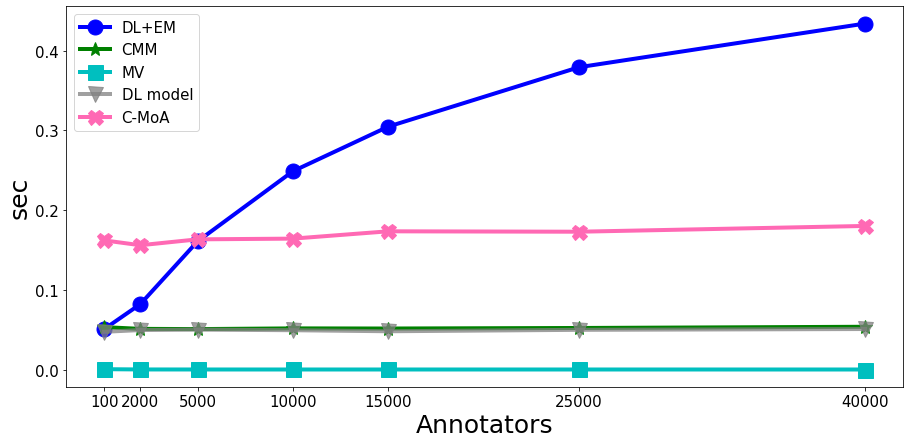

In [70]:
plt.figure(figsize=(15,7))
plt.plot(to_check,raykar_exec,'bo-',label="DL+EM", markersize=ms,linewidth=lw)
plt.plot(to_check,ourglobal_exec,'g*-',label="CMM", markersize=ms,linewidth=lw)
plt.plot(to_check,mv_exec,'cs-',label="MV", markersize=ms,linewidth=lw)
#plt.plot(to_check,ds_exec,'v-',label="DS", color='orange', markersize=ms,linewidth=lw)
plt.plot(to_check,DL_exec,'v-',label="DL model", color='grey', markersize=ms,linewidth=lw, alpha=0.75)

#plt.plot(to_check,ourindiv1_exec,'X-',label="C-MoA (T)", color='purple', markersize=ms,linewidth=lw)
#plt.plot(to_check,ourindiv2_exec,'X-',label="Ours-Indiv (param-T) iter exec", color='magenta',markersize=ms,linewidth=lw)
plt.plot(to_check,ourindiv3_exec_v2,'X-',label="C-MoA", color='hotpink', markersize=ms,linewidth=lw)
plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
plt.legend()
plt.show()

### Comparison between all-EM methods

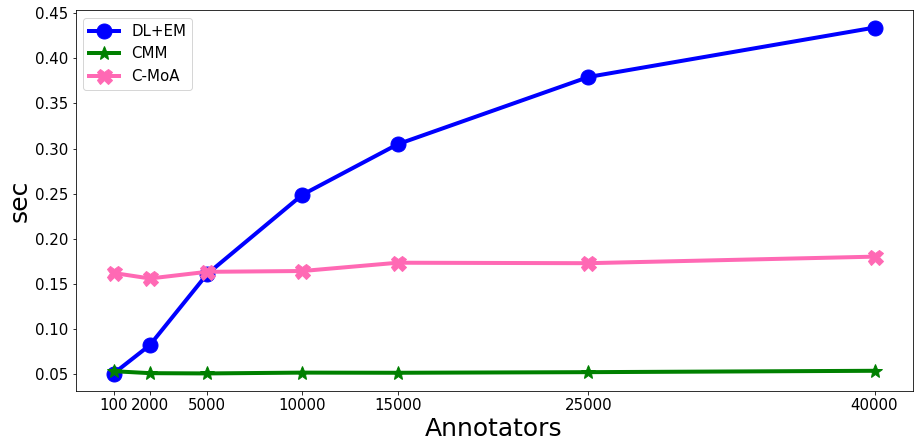

In [72]:
plt.figure(figsize=(15,7))
plt.plot(to_check,raykar_exec,'bo-',label="DL+EM", markersize=ms,linewidth=lw)
plt.plot(to_check,ourglobal_exec,'g*-',label="CMM", markersize=ms,linewidth=lw)

#plt.plot(to_check,ourindiv1_exec,'X-',label="C-MoA (T)", color='purple', markersize=ms,linewidth=lw)
#plt.plot(to_check,ourindiv2_exec,'X-',label="Ours-Indiv (param-T) iter exec", color='magenta',markersize=ms,linewidth=lw)
plt.plot(to_check,ourindiv3_exec_v2,'X-',label="C-MoA", color='hotpink', markersize=ms,linewidth=lw)

plt.xticks(to_check)
plt.ylabel("sec")
plt.xlabel("Annotators")
plt.legend()
plt.show()

tiempo de ejecucion aumentando el numero de grupos M.. comparando la linea horizontal de raykar y global